In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import joblib
from rasterio.mask import geometry_mask
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

import dask
import dask.array as da
import joblib
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import matplotlib.colors as mcolors
from sklearn.ensemble import RandomForestClassifier
from dask.diagnostics import ProgressBar

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [3]:
# Function to calculate and print class distribution
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Function to calculate and print class distribution by island
def print_class_distribution_by_island(df, name):
    class_counts = df.groupby(['image_name', 'encoded_labels']).size().unstack(fill_value=0)
    class_counts = class_counts.reset_index()
    class_counts['island'] = class_counts['image_name'].apply(lambda x: extract_island_and_date(x)[0])
    print(f"\n{name} Class Distribution by Island:")
    print(class_counts)

In [4]:
# Apply SMOTE to the training data and keep image names
def apply_smote_with_images(train_df):
    smote = SMOTE(random_state=42)
    X_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values
    y_train = train_df['encoded_labels'].values
    image_names = train_df['image_name'].values

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Create a DataFrame for SMOTE applied data with image names
    smote_df = pd.DataFrame(X_train_smote, columns=train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).columns)
    smote_df['encoded_labels'] = y_train_smote

    # Repeat image names to match the number of rows in smote_df
    repeat_factor = X_train_smote.shape[0] // len(image_names) + 1
    repeated_image_names = np.tile(image_names, repeat_factor)[:X_train_smote.shape[0]]
    smote_df['image_name'] = repeated_image_names

    return smote_df

In [5]:
# Ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df


In [6]:
# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Print class distributions before SMOTE
print_class_distribution(train_df, "Training Before SMOTE")
print_class_distribution(test_df, "Test")


Training Before SMOTE Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10


In [7]:
# Apply SMOTE and get the augmented training DataFrame
train_df_smote = apply_smote_with_images(train_df)

# Print class distributions after SMOTE
print_class_distribution(train_df_smote, "Training After SMOTE")


Training After SMOTE Class Distribution:
walrus_mixed: 623431
ocean: 623431
rock: 623431
freshwater: 623431
ice: 623431
walrus_pure: 623431



Training After SMOTE Class Distribution:
walrus_mixed: 623431
ocean: 623431
rock: 623431
freshwater: 623431
ice: 623431
walrus_pure: 623431


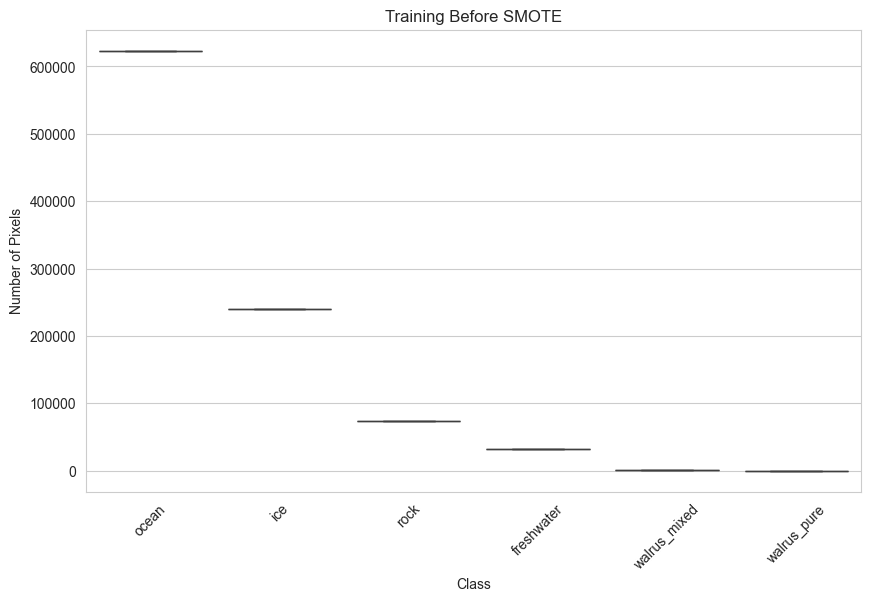

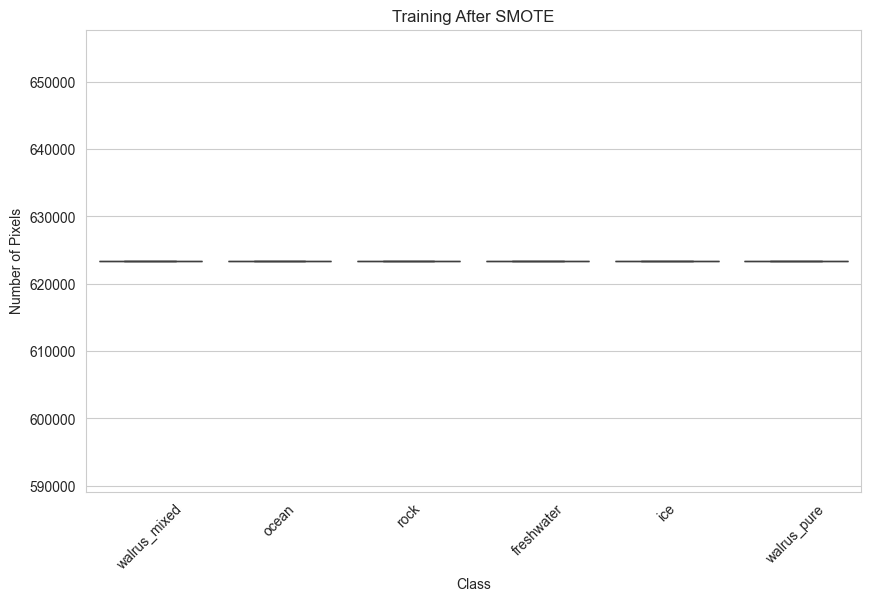

In [8]:
# Function to print class distribution
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

print_class_distribution(train_df_smote, "Training After SMOTE")

# Visualize class distributions using box plots
def plot_class_distribution(df, title):
    class_counts = df['encoded_labels'].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    class_counts['Class'] = le.inverse_transform(class_counts['Class'])
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Class', y='Count', data=class_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Pixels')
    plt.show()

plot_class_distribution(train_df, "Training Before SMOTE")
plot_class_distribution(train_df_smote, "Training After SMOTE")


In [9]:
# Print class distribution by island after SMOTE
print_class_distribution_by_island(train_df_smote, "Training After SMOTE")


Training After SMOTE Class Distribution by Island:
encoded_labels                                         image_name       0  \
0               C:\Users\Student\Documents\101_walrus_data\tra...   99937   
1               C:\Users\Student\Documents\101_walrus_data\tra...  167392   
2               C:\Users\Student\Documents\101_walrus_data\tra...  142574   
3               C:\Users\Student\Documents\101_walrus_data\tra...   60860   
4               C:\Users\Student\Documents\101_walrus_data\tra...   54358   
5               C:\Users\Student\Documents\101_walrus_data\tra...   51052   
6               C:\Users\Student\Documents\101_walrus_data\tra...   23041   
7               C:\Users\Student\Documents\101_walrus_data\tra...   19786   
8               C:\Users\Student\Documents\101_walrus_data\tra...       0   
9               C:\Users\Student\Documents\101_walrus_data\tra...       0   
10              C:\Users\Student\Documents\101_walrus_data\tra...     976   
11              C:\Users

In [11]:
# Train the Random Forest model using the SMOTE data
X_train_smote = train_df_smote.drop(columns=['encoded_labels', 'image_name']).values
y_train_smote = train_df_smote['encoded_labels'].values

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

# Save the model
model_filename = "RF_allislands_SMOTE.joblib"
joblib.dump(model, model_filename)

['RF_allislands_SMOTE.joblib']

In [10]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

NameError: name 'model' is not defined

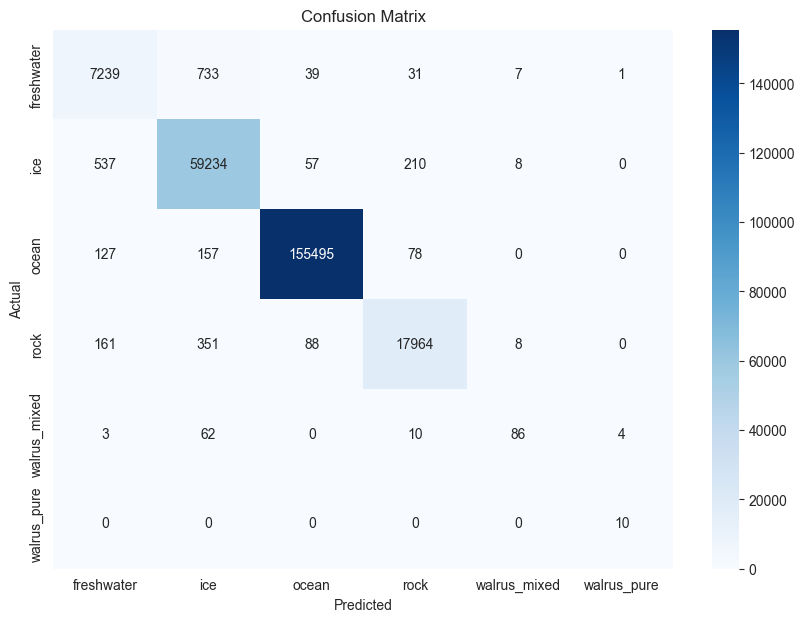

In [27]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

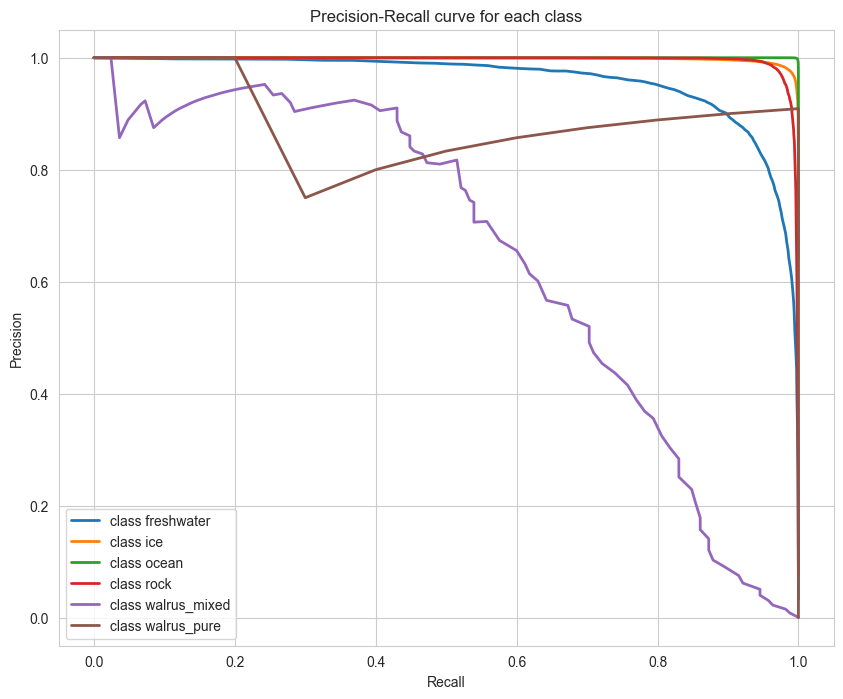

In [30]:
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.arange(len(le.classes_)))
y_score = model.predict_proba(X_test)

# Compute Precision-Recall and plot curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_test_binarized.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label='class {}'.format(le.classes_[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="best")
plt.show()


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


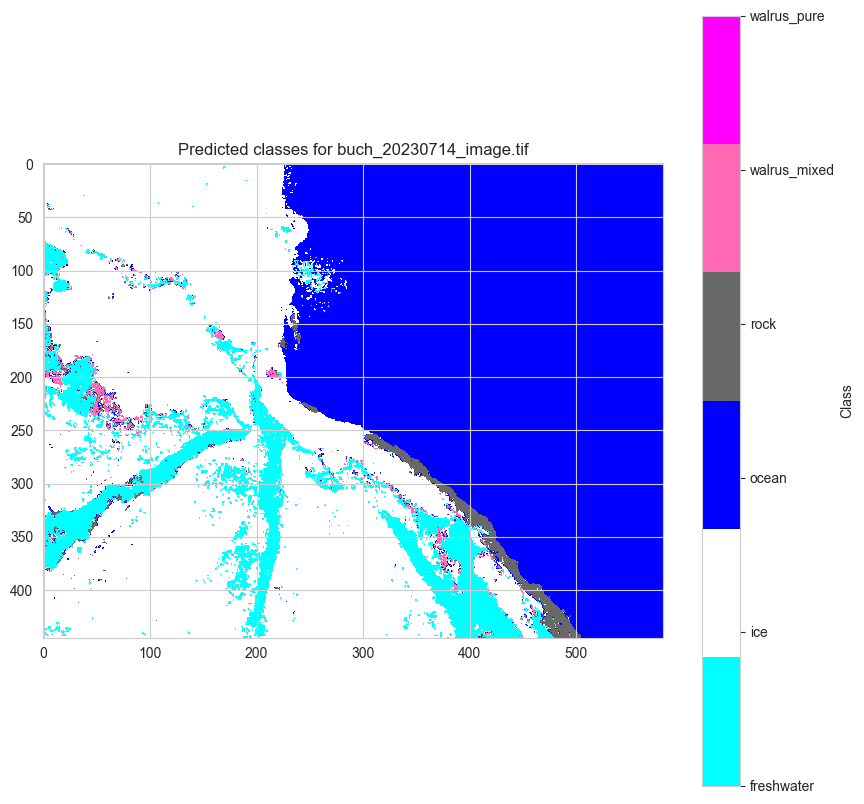

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


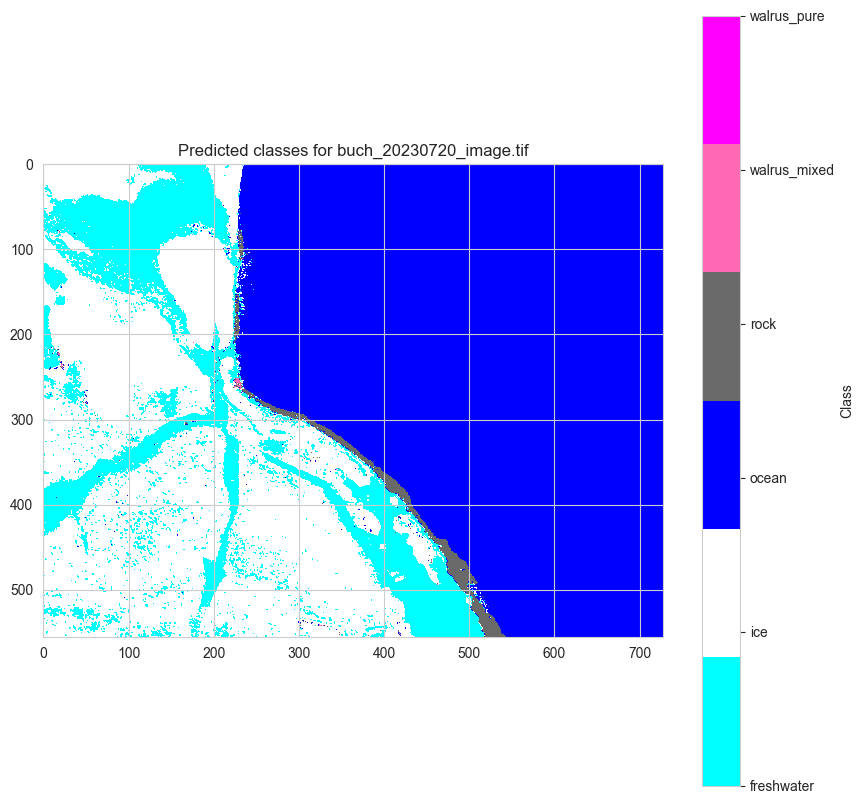

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


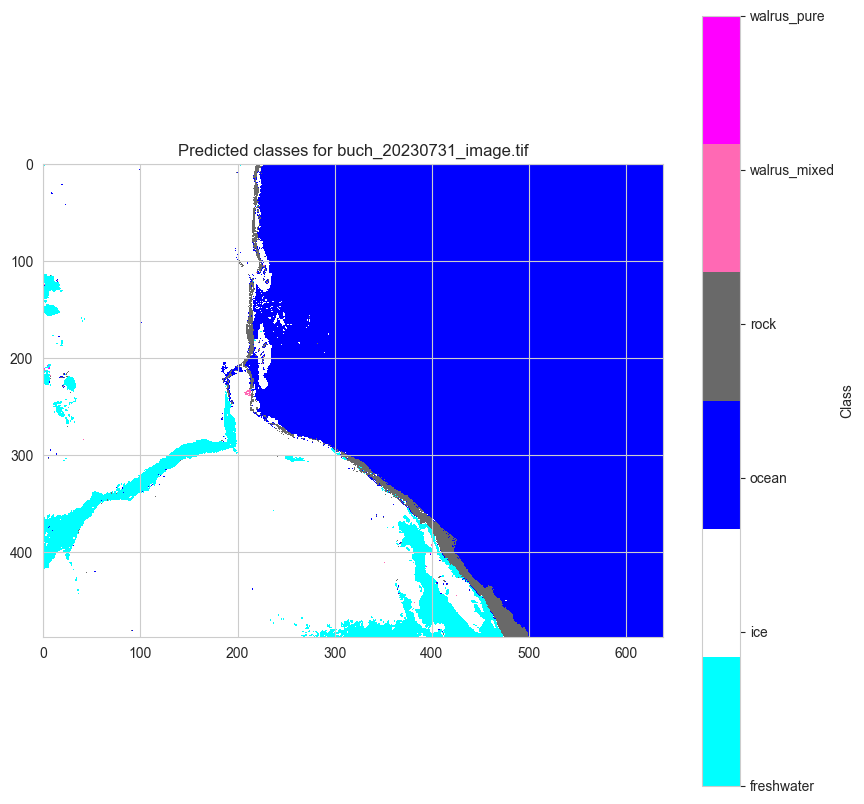

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


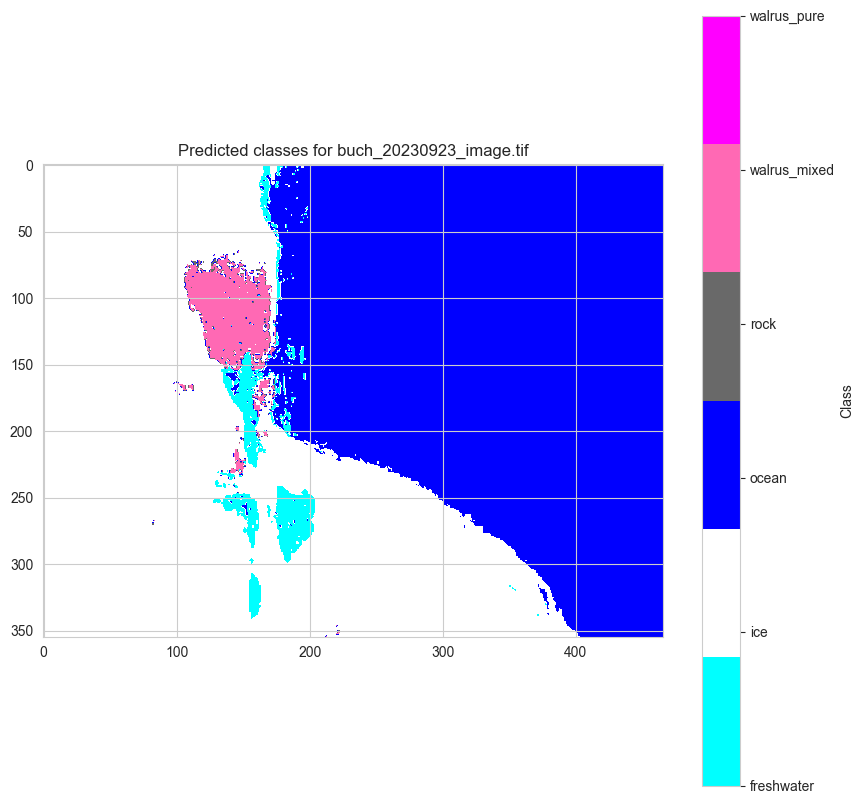

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


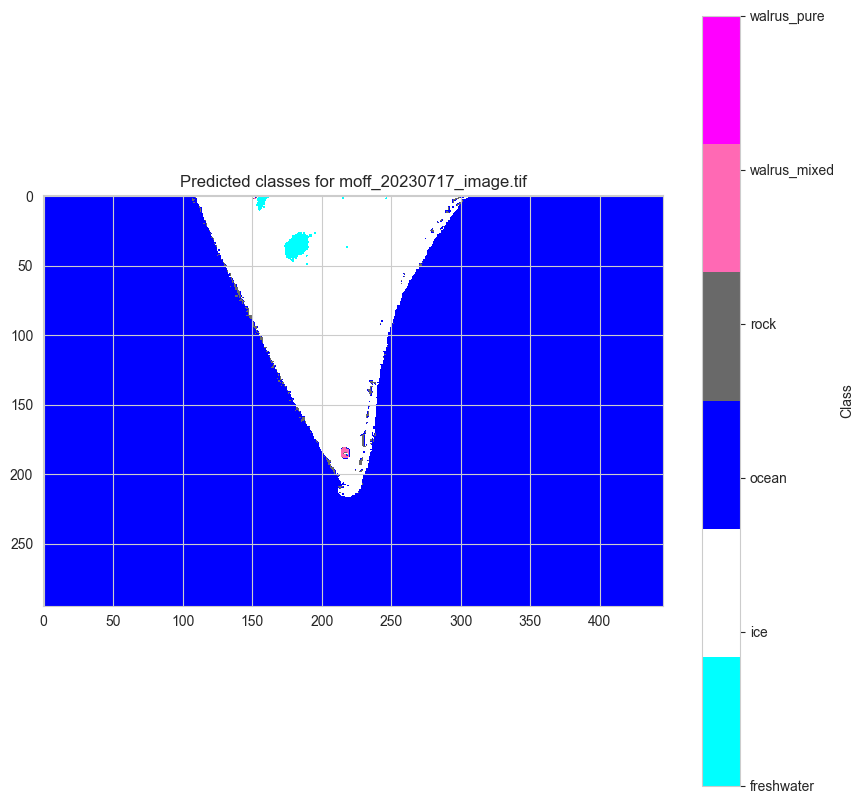

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


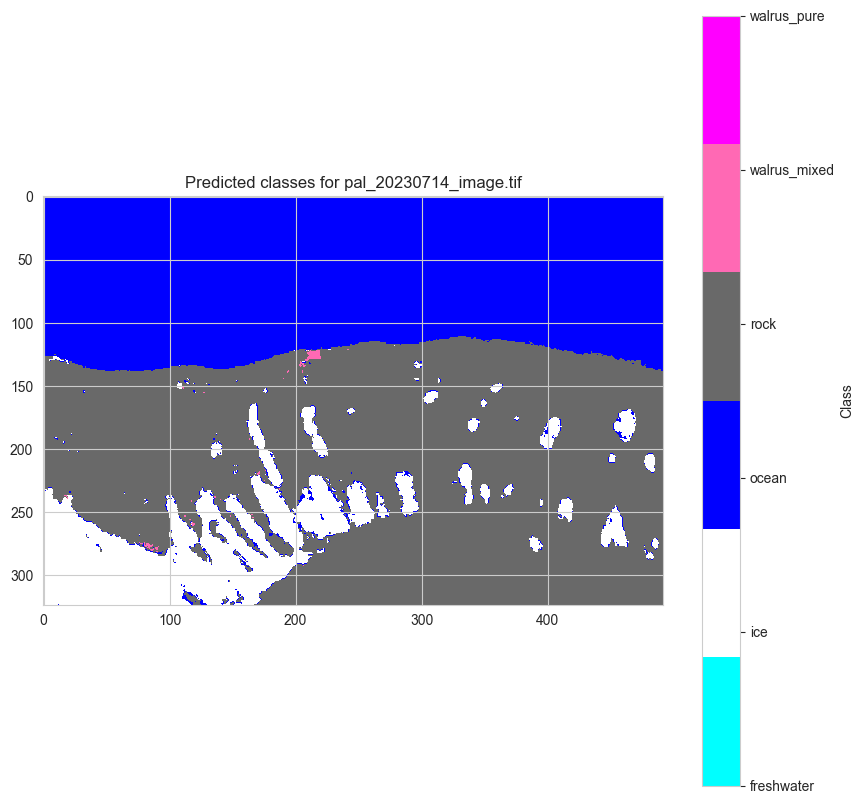

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


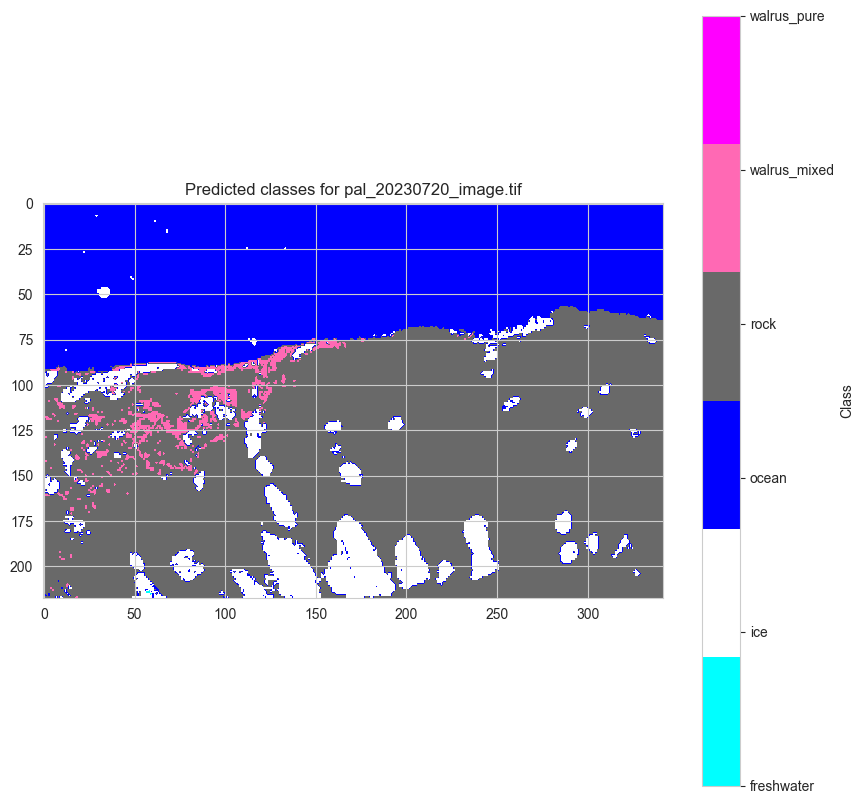

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


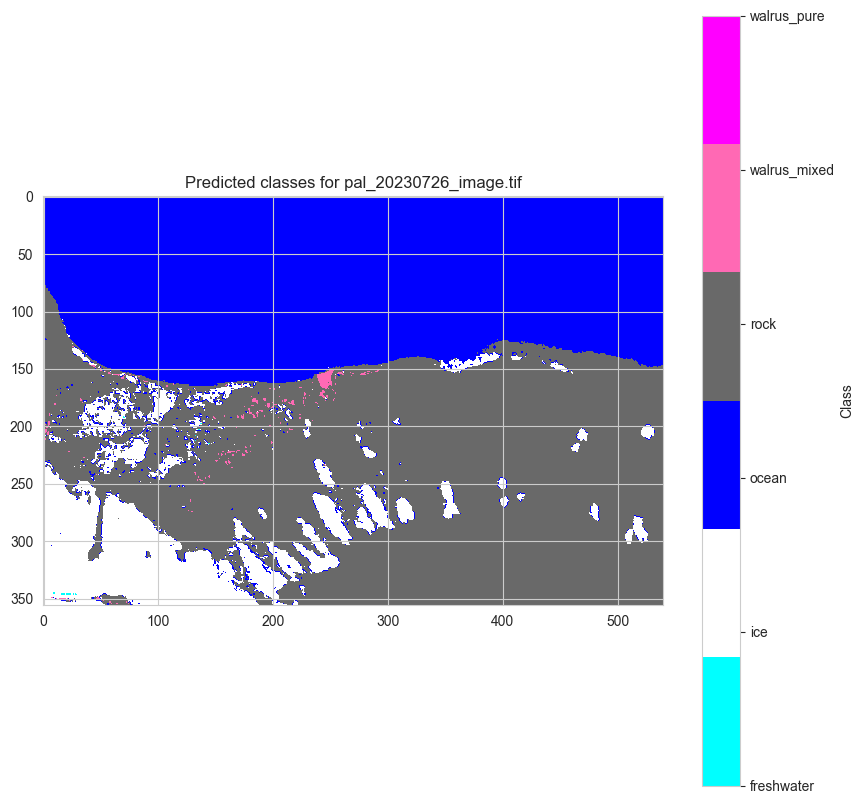

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


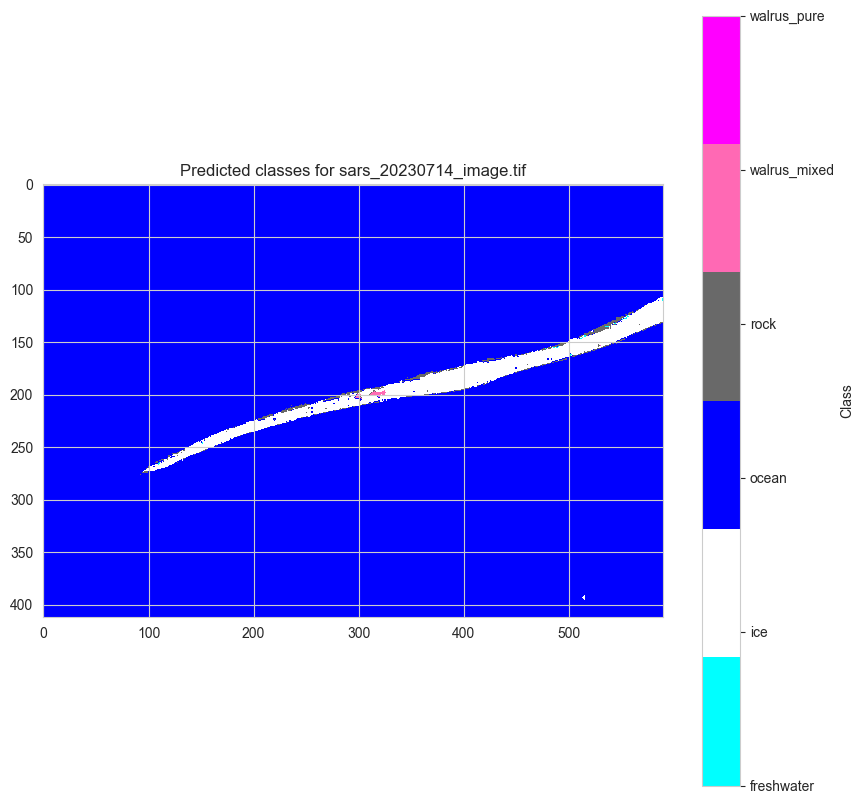

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


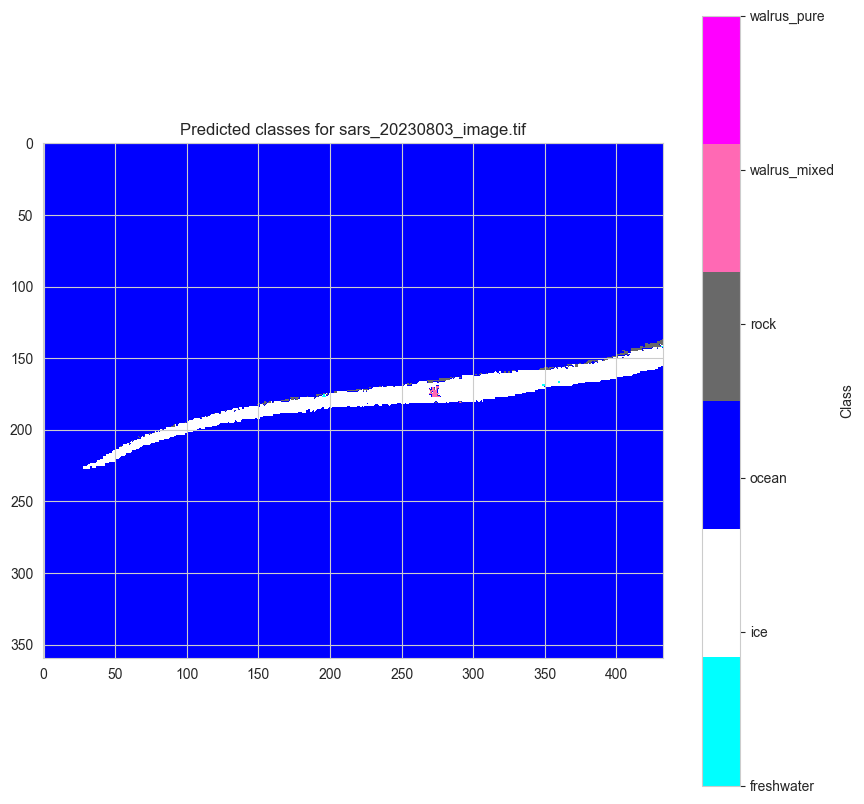

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


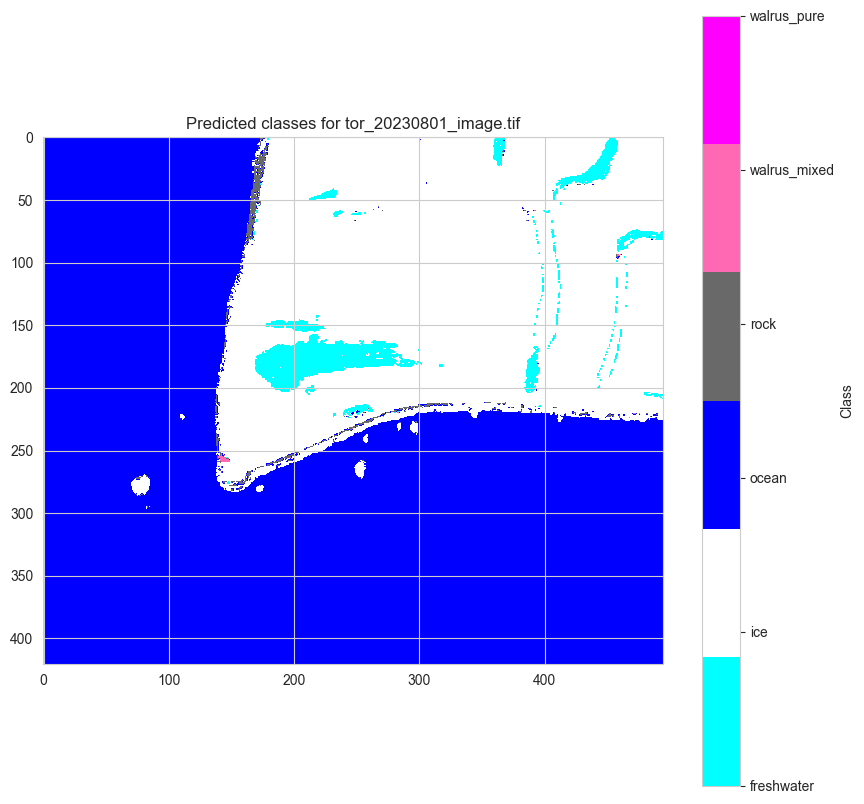

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


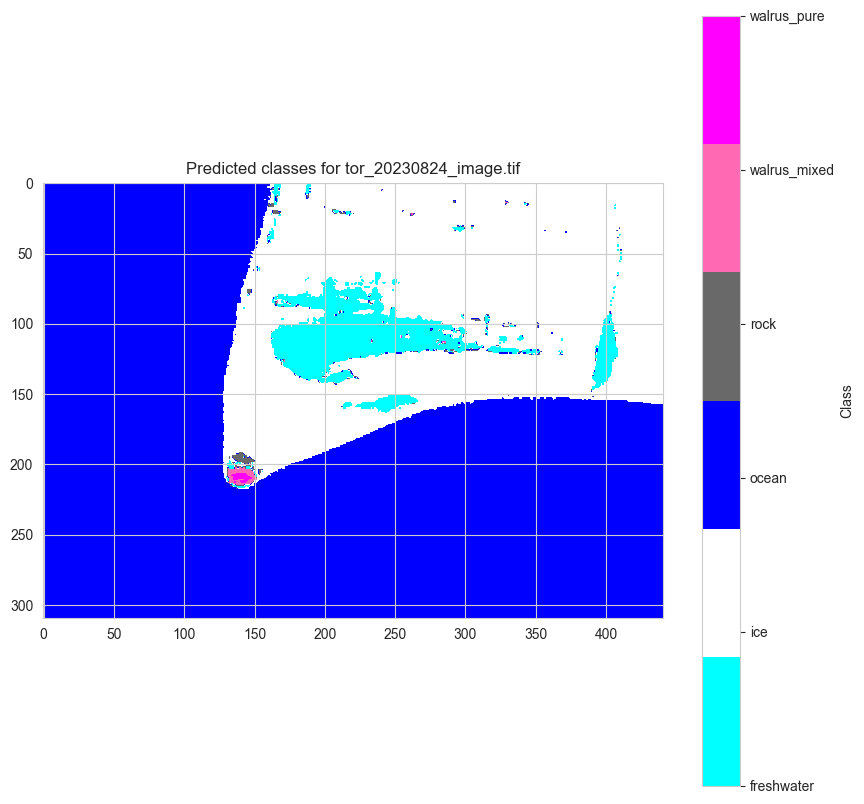

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


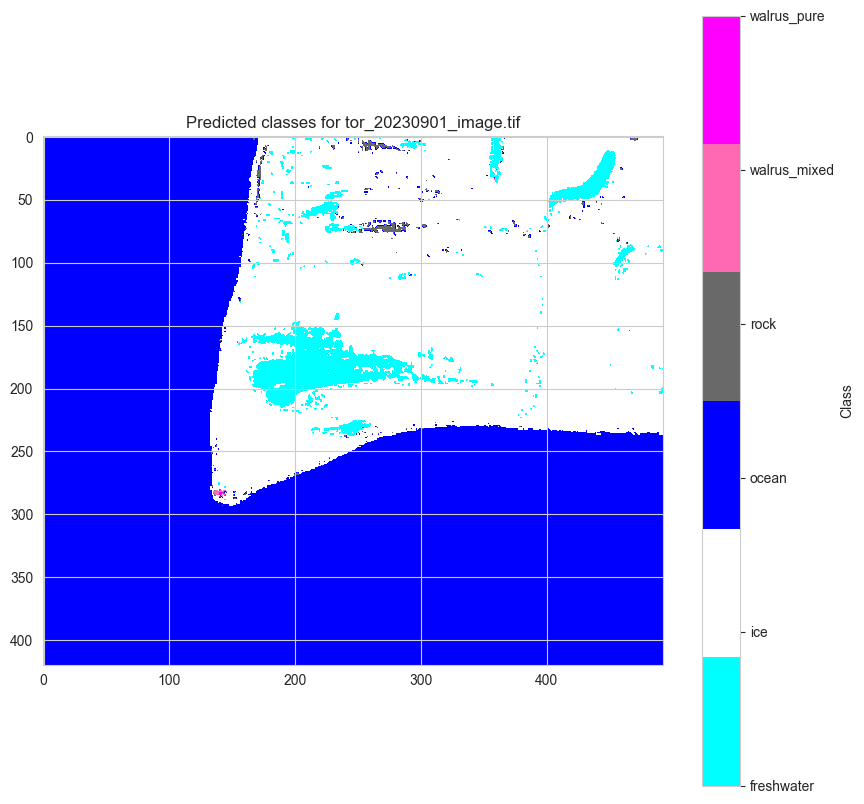

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


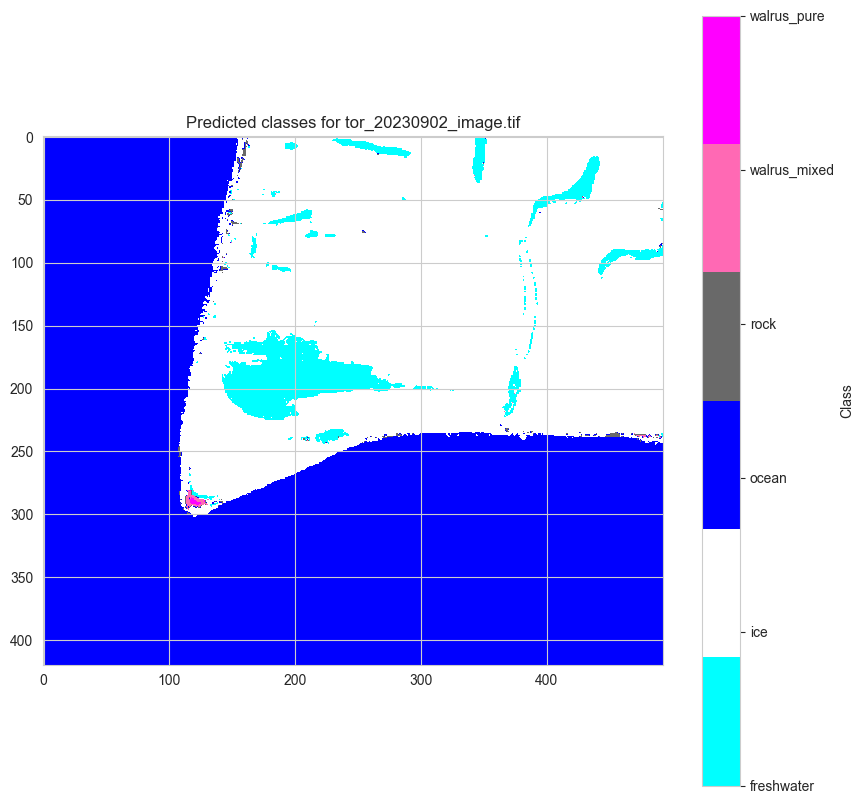

In [31]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

In [13]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

Model loaded from RF_allislands_SMOTE.joblib


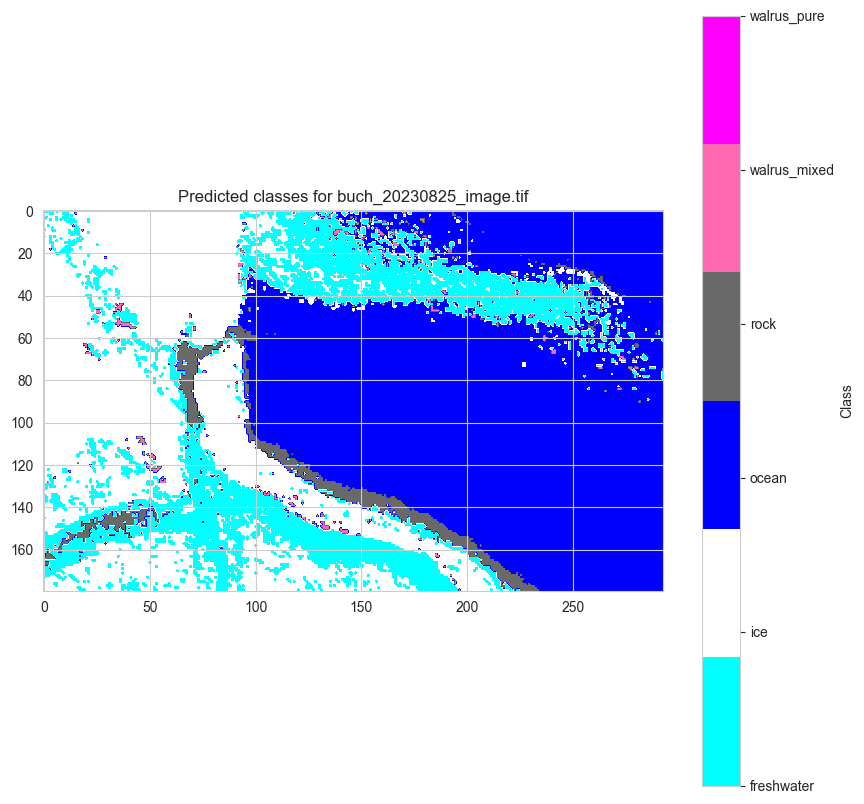

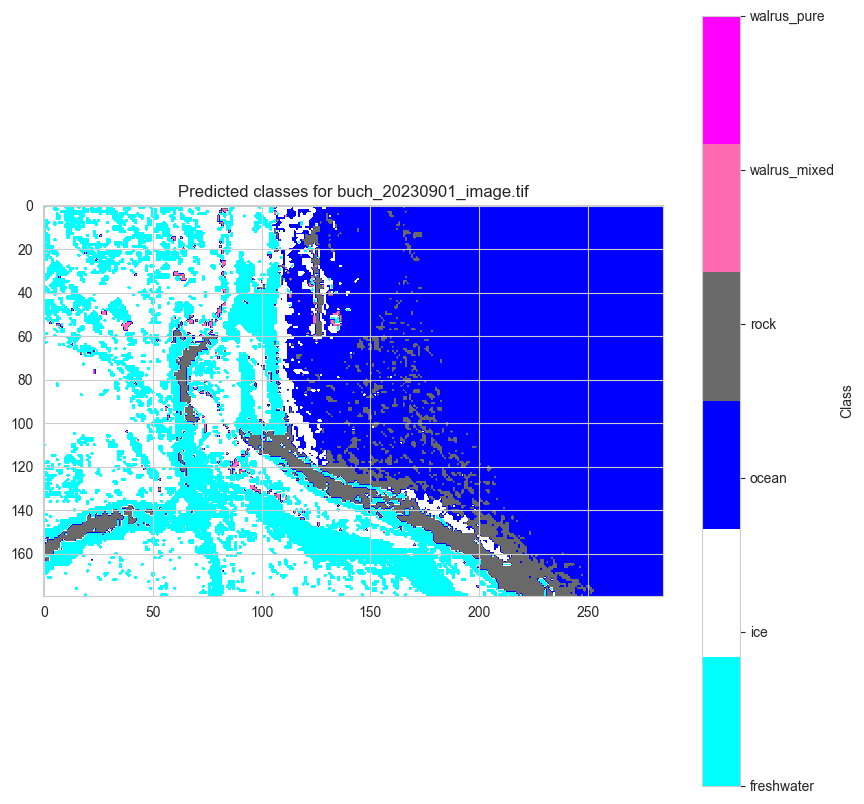

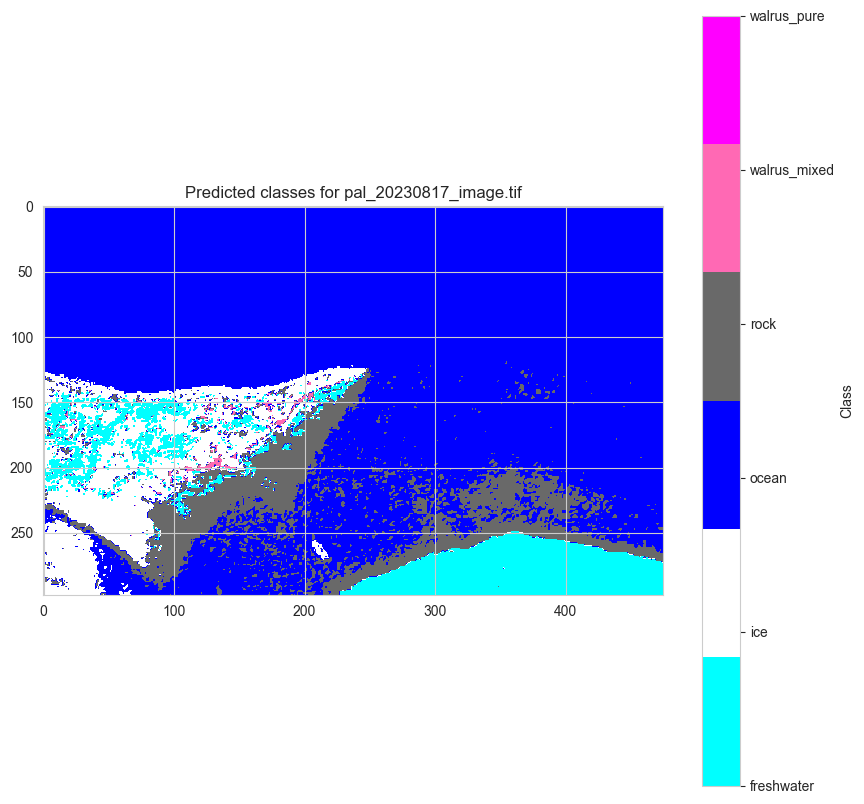

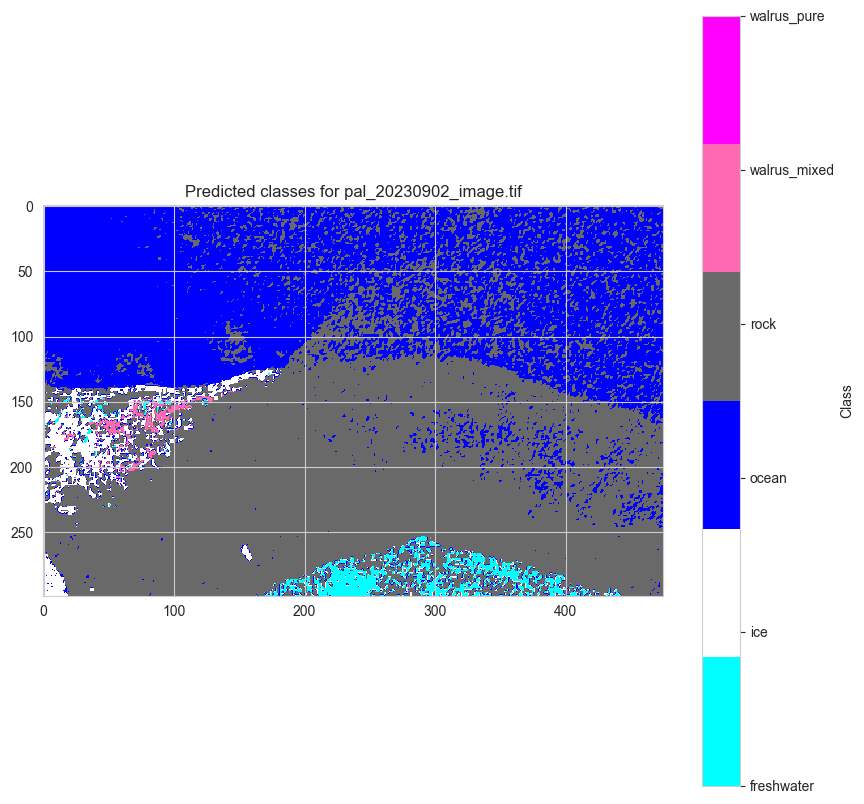

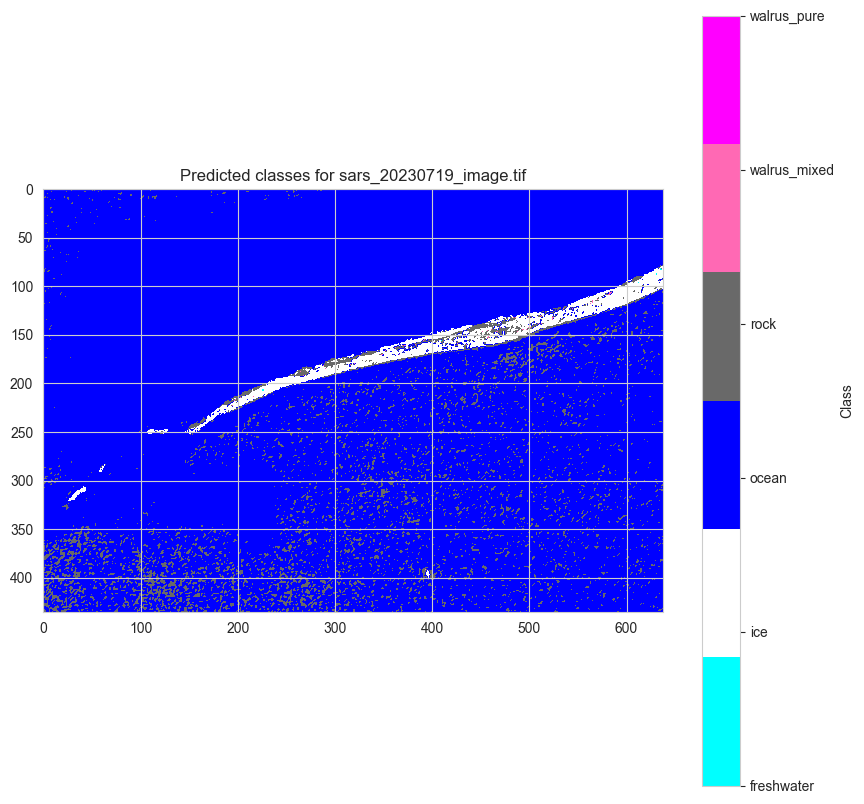

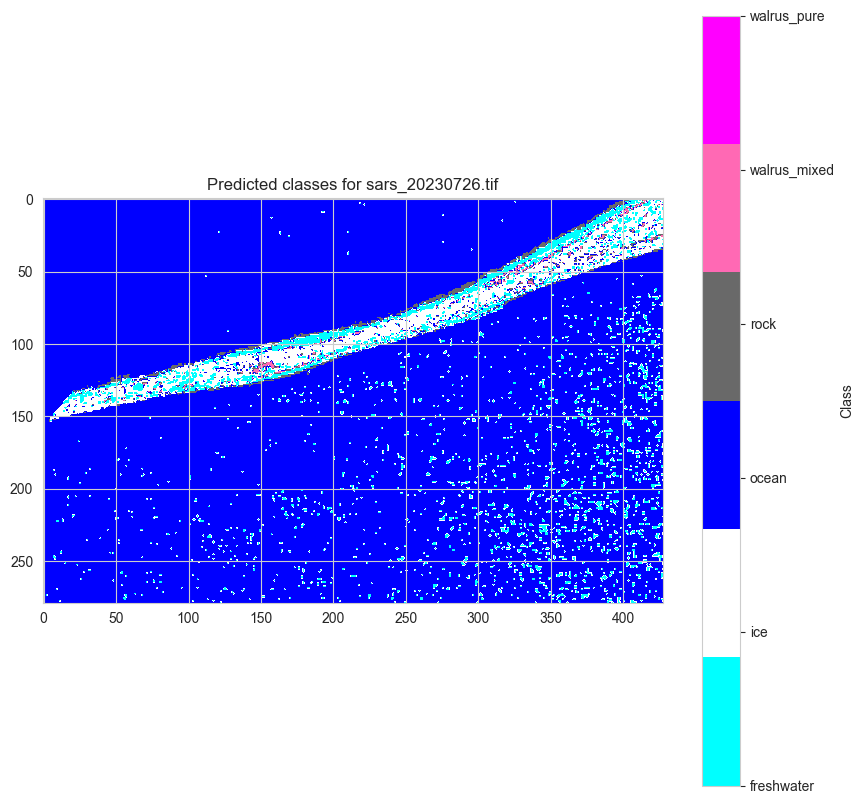

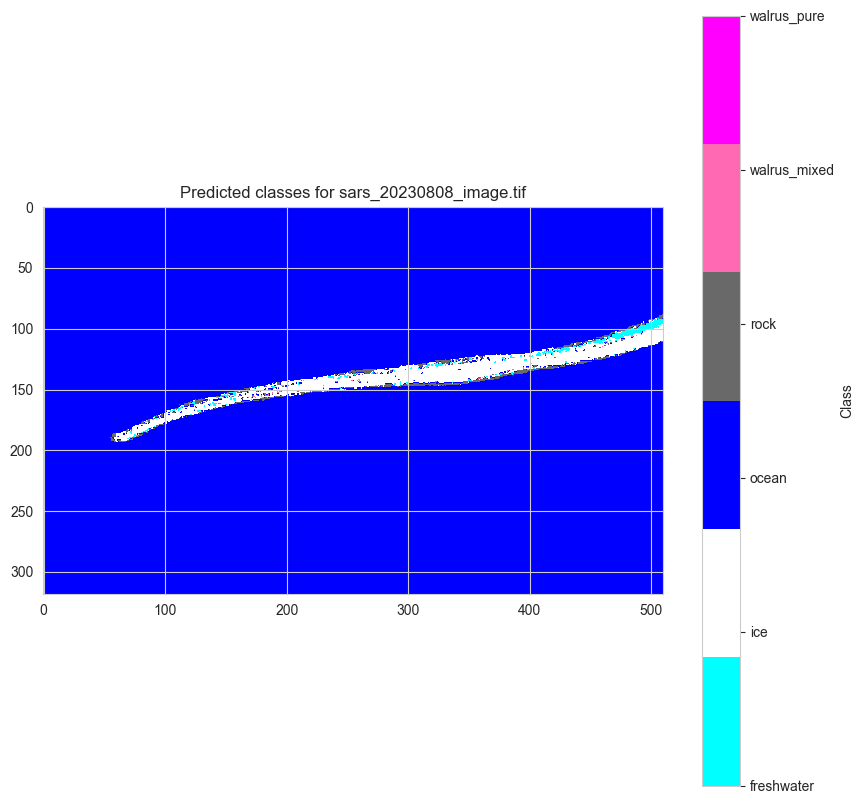

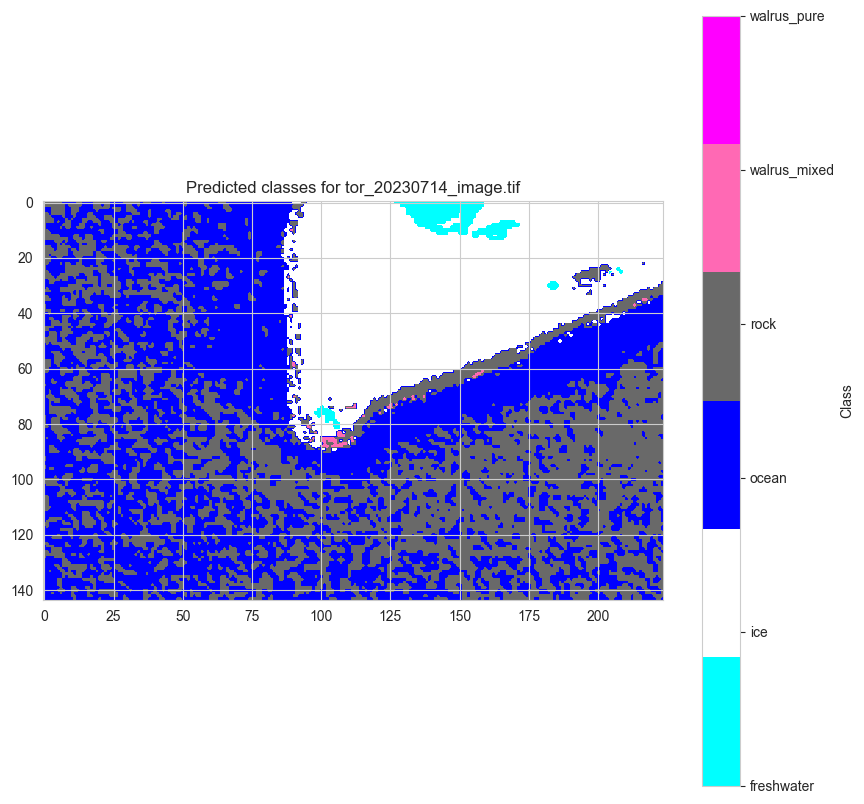

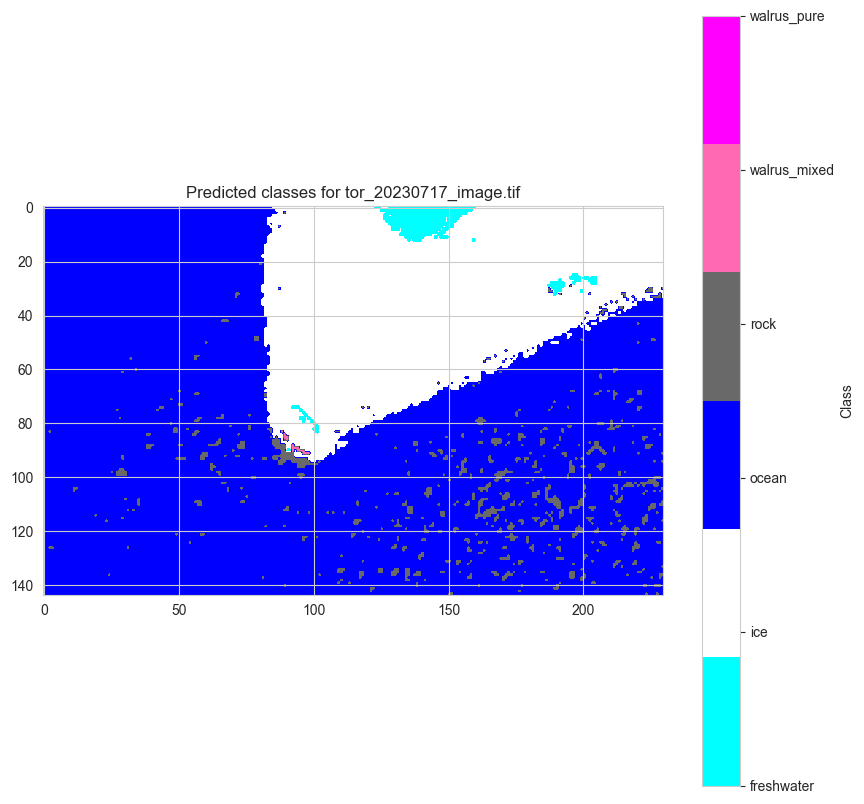

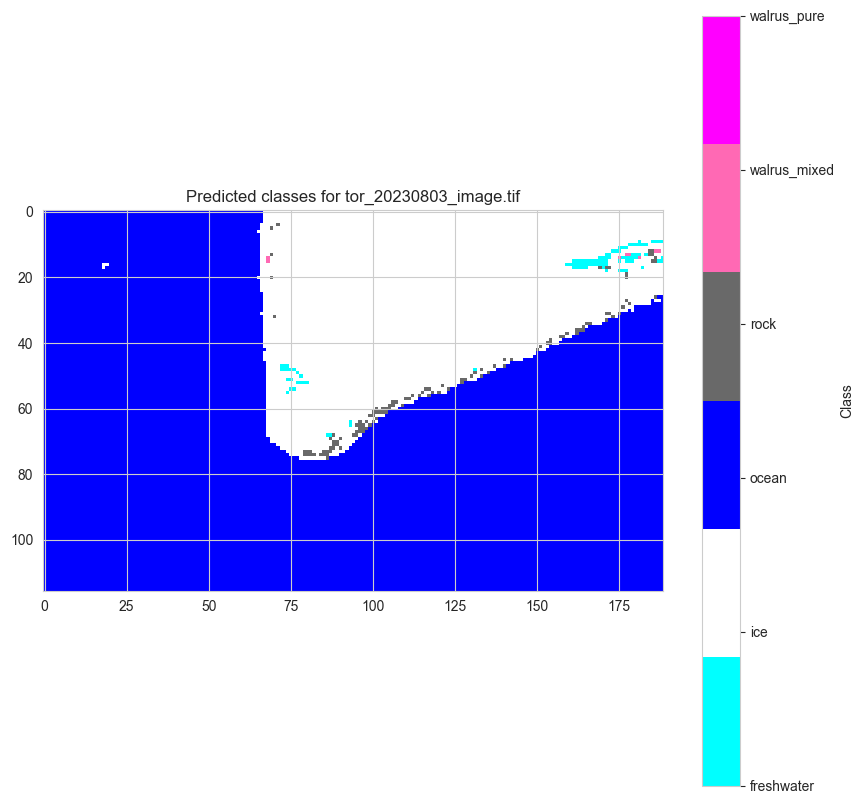

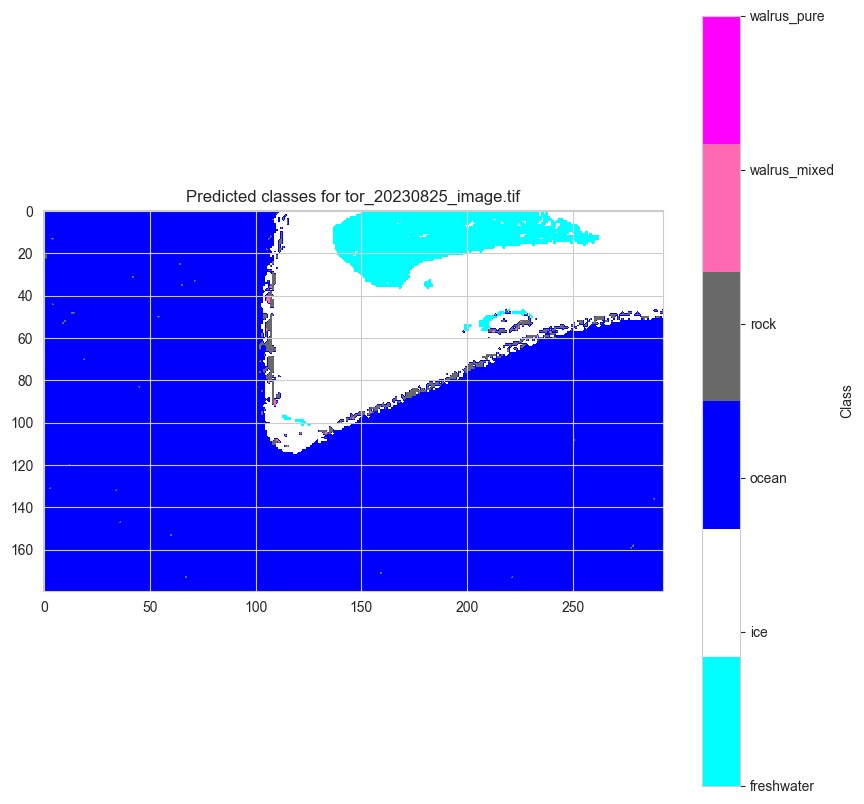

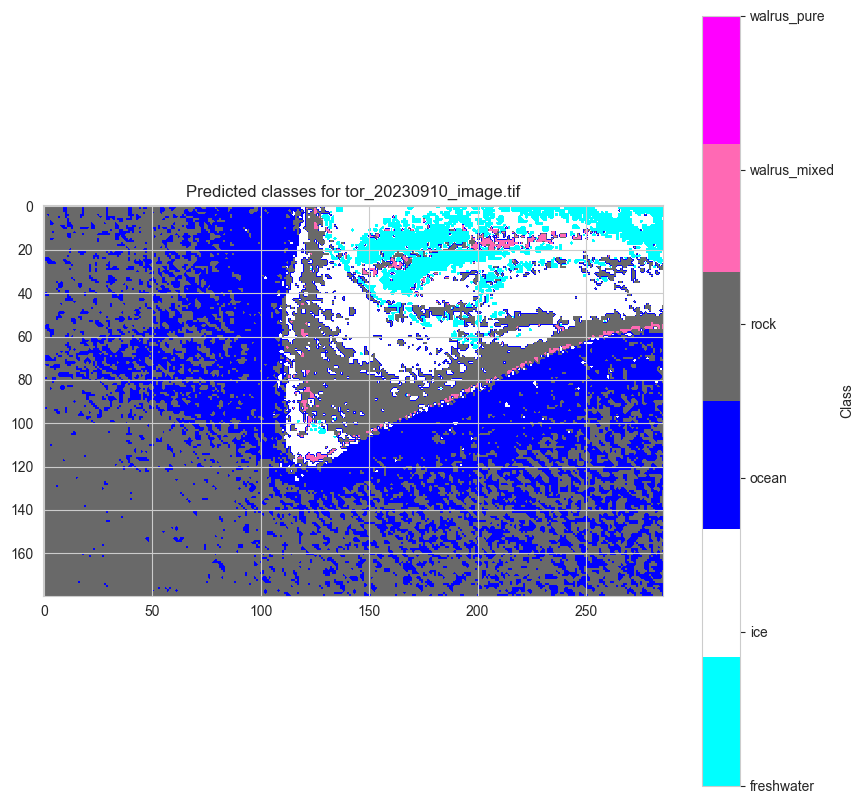

In [16]:
# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()

In [42]:
# Function to predict classes for a given image using Dask
def predict_image_in_tiles_dask(image_path, model, tile_size=256):
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = image.shape[1], image.shape[2]
        
        predicted_image = np.zeros((height, width), dtype=np.uint8)

        for i in range(0, height, tile_size):
            for j in range(0, width, tile_size):
                tile = image[:, i:i+tile_size, j:j+tile_size]
                tile_reshaped = tile.reshape((tile.shape[0], -1)).T
                if tile_reshaped.shape[0] > 0:  # Ensure there are pixels to predict
                    tile_dask = da.from_array(tile_reshaped, chunks=(1000, tile_reshaped.shape[1]))
                    predictions = dask.delayed(model.predict)(tile_dask)
                    predictions = predictions.compute()
                    predicted_image[i:i+tile_size, j:j+tile_size] = predictions.reshape(tile.shape[1], tile.shape[2])

        return predicted_image

In [43]:
# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
le_classes = ['ice', 'rock', 'walrus_pure', 'walrus_mixed', 'freshwater', 'ocean']
cmap = mcolors.ListedColormap([label_colors[label] for label in le_classes])

# Load the model using joblib
model_filename = "RF_allislands_SMOTE.joblib"
with ProgressBar():
    model = joblib.load(model_filename)

MemoryError: could not allocate 18817392 bytes

In [33]:
# Save the model using joblib with a memory-mapped file
model_filename = "RF_allislands_SMOTE_memmap.joblib"
joblib.dump(model, model_filename, compress=3)

['RF_allislands_SMOTE_memmap.joblib']

In [39]:
# Load the model using memory mapping
model_filename = "RF_allislands_SMOTE.joblib"

# Loading the model using joblib
model = joblib.load(model_filename)

MemoryError: could not allocate 25373248 bytes

In [37]:

# Load the model without memory mapping
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

MemoryError: could not allocate 25347136 bytes

In [38]:
# Load the model without memory mapping
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

# Process images in smaller tiles to manage memory usage
batch_size = 5  # Adjust batch size based on memory availability

for i in range(0, len(unlabeled_image_paths), batch_size):
    batch_paths = unlabeled_image_paths[i:i + batch_size]
    for image_path in batch_paths:
        predicted_image = predict_image_in_tiles(image_path, loaded_model)

        plt.figure(figsize=(10, 10))
        plt.title(f"Predicted classes for {os.path.basename(image_path)}")
        plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le_classes)-1)

        cbar = plt.colorbar(ticks=range(len(le_classes)), label='Class')
        cbar.ax.set_yticklabels(le_classes)

        plt.show()

MemoryError: could not allocate 25256384 bytes

In [34]:
# Load the model using memory mapping
loaded_model = joblib.load(model_filename, mmap_mode='r')
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)

    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)

    plt.show()

C:\Users\Student\AppData\Local\Programs\Python\Python39\lib\contextlib.py:119: UserWarning: mmap_mode "r" is not compatible with compressed file RF_allislands_SMOTE_memmap.joblib. "r" flag will be ignored.
  return next(self.gen)


ValueError: Wrong shape for value array from the pickle: expected (392827, 1, 114603733), got (392827, 1, 6)

In [35]:
batch_size = 10  # Adjust batch size based on memory availability

for i in range(0, len(unlabeled_image_paths), batch_size):
    batch_paths = unlabeled_image_paths[i:i + batch_size]
    for image_path in batch_paths:
        predicted_image = predict_image(image_path, loaded_model)

        plt.figure(figsize=(10, 10))
        plt.title(f"Predicted classes for {os.path.basename(image_path)}")
        plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

        cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
        cbar.ax.set_yticklabels(le.classes_)

        plt.show()


NameError: name 'loaded_model' is not defined

In [12]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)

    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)

    plt.show()

Model loaded from RF_allislands_SMOTE.joblib


NameError: name 'predict_image' is not defined